In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime

2024-05-13 12:41:20.664047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 12:41:20.716188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 12:41:20.716222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 12:41:20.717240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 12:41:20.725235: I tensorflow/core/platform/cpu_feature_guar

In [4]:
seed=360
num_components=4
learning_rate = 0.05
epochs=200
outdir = '/cluster/home/kheuto01/testdir'
penalty = 5000
threshold = 0.55
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500
perturbed_sigma=0.3
num_score_func_samples=10
batch_size=50

In [5]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed, batch_size=batch_size)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)
input_shape = (H,S)

bpr_K = get_perturbed_bpr_func(K, sigma=perturbed_sigma)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


In [6]:
model  = get_mixture(location_specific_linear, input_shape, num_components=num_components)

In [7]:
@tf.function
def get_sample_log_probs(mixture, num_score_func_samples):
    # todo concretize this
    sample_y_MBS = mixture.sample(num_score_func_samples)+1e-9
    sample_log_probs_MBS = mixture.log_prob(sample_y_MBS)

    return sample_y_MBS, sample_log_probs_MBS

@tf.function
def get_expected_decisions(sample_y_MBS):
    sample_decisions_MBS = cross_ratio_decision(sample_y_MBS)
    expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

    return sample_decisions_MBS, expected_decisions_BS

@tf.function
def get_loss(mixture, y_BS, expected_decisions_BS, bpr_K):
    bpr_B = bpr_K(y_BS, expected_decisions_BS)
    observed_log_prob_BS = mixture.log_prob(y_BS)

    loss_B = -tf.reduce_sum(observed_log_prob_BS, axis=-1)
    violate_threshold_flag_B = tf.cast(tf.greater(threshold,
                                                bpr_B),
                                        tf.float32)
    loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)
    return observed_log_prob_BS, bpr_B, loss_B


In [8]:
verbose=True
tf.debugging.disable_check_numerics()
losses = {}
losses['train'] = {}
losses['val'] ={}
losses['train']['loss']=[]
losses['train']['nll']=[]
losses['train']['bpr']=[]
losses['val']['loss']=[]
losses['val']['nll']=[]
losses['val']['bpr']=[]
for epoch in range(200):
    if verbose:
        print(f'Epoch {epoch}')
    else:
        if epoch % 10 == 0:
            print(f'Epoch {epoch}')

    batch_losses = {'train': {'loss': [], 'nll': [], 'bpr': []}}

    for step, (x_BHS, y_BS) in enumerate(train_dataset):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
            #print('before forward')
            mixture = model(x_BHS, training=True)
            #print('before sample log prob')
            #sample_y_MBS = mixture.sample(num_score_func_samples)+1e-9
            #sample_log_probs_MBS = mixture.log_prob(sample_y_MBS)
            sample_y_MBS, sample_log_probs_MBS = get_sample_log_probs(mixture, num_score_func_samples)
            #print(tf.reduce_min(sample_log_probs_MBS), tf.reduce_max(sample_log_probs_MBS))
            #print(tf.reduce_min(sample_y_MBS), tf.reduce_max(sample_y_MBS))
            #print('before decision')
            sample_decisions_MBS, expected_decisions_BS = get_expected_decisions(sample_y_MBS)
            #print('before loss  ')
            #bpr_B = bpr_K(y_BS, expected_decisions_BS)
            #observed_log_prob_BS = mixture.log_prob(y_BS)

            #loss_B = -tf.reduce_sum(observed_log_prob_BS, axis=-1)
            #violate_threshold_flag_B = tf.cast(tf.greater(threshold,
            #                                            bpr_B),
            #                                    tf.float32)
            #loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)
            observed_log_prob_BS, bpr_B, loss_B = get_loss(mixture, y_BS, expected_decisions_BS, bpr_K)
        #print('before jac')
        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        #print('before loss grad')
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        #print('before score func')
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        #print('before overall grad')
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))
        # print overall min and max of all trainable variables
        #print('min', tf.reduce_min(tf.concat([tf.reshape(v, [-1]) for v in model.trainable_variables], axis=0)))
        #print('max', tf.reduce_max(tf.concat([tf.reshape(v, [-1]) for v in model.trainable_variables], axis=0)))
        batch_losses['train']['loss'].append(tf.reduce_mean(loss_B))
        batch_losses['train']['nll'].append(tf.reduce_mean(tf.reduce_sum(observed_log_prob_BS, axis=-1)))
        batch_losses['train']['bpr'].append(tf.reduce_mean(bpr_B))
    losses['train']['loss'].append(tf.reduce_mean(batch_losses['train']['loss']))
    losses['train']['nll'].append(tf.reduce_mean(batch_losses['train']['nll']))
    losses['train']['bpr'].append(tf.reduce_mean(batch_losses['train']['bpr']))
    if verbose:
        # print all metrics
        print(f'Loss: {losses["train"]["loss"][-1]}')
        print(f'NLL: {losses["train"]["nll"][-1]}')
        print(f'BPR: {losses["train"]["bpr"][-1]}')


Epoch 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Loss: 540.0674438476562
NLL: -131.29800415039062
BPR: 0.4816523790359497
Epoch 1
Loss: 514.5830688476562
NLL: -128.33047485351562
BPR: 0.4868086278438568
Epoch 2
Loss: 497.7715759277344
NLL: -125.3602294921875
BPR: 0.4879882037639618
Epoch 3
Loss: 481.0760803222656
NLL: -124.8301010131

In [42]:
loss_gradients_BS

In [6]:
for step, (x_BHS, y_BS) in enumerate(train_dataset):
    thing = model(x_BHS, training=True)

min tf.Tensor(-1.0510222, shape=(), dtype=float32)
max tf.Tensor(1.181708, shape=(), dtype=float32)


In [36]:
thing.log_prob(y_BS)

<tf.Tensor: shape=(50, 12), dtype=float32, numpy=
array([[  -3.6898859 ,   -3.69673   ,   -3.7260506 ,   -3.6843398 ,
          -0.78671205,   -0.7241421 ,   -1.1344442 ,   -1.3474755 ,
          -0.70310897,   -0.6931472 ,   -0.6931472 ,   -0.6931473 ],
       [  -3.6898859 ,   -3.69673   ,   -3.7260506 ,   -3.6843398 ,
          -4.033942  ,   -4.0633507 ,   -3.477567  ,   -1.3474755 ,
          -0.69314706,   -0.6931472 ,   -0.6931472 ,   -0.6931473 ],
       [  -3.6898859 ,   -3.69673   ,   -3.7260506 ,   -3.6843398 ,
          -4.033942  ,   -0.68557274,   -4.073748  ,   -3.4817696 ,
          -0.69314706,   -0.6931472 ,   -0.7060341 ,   -0.6931473 ],
       [  -3.6898859 ,   -3.69673   ,   -3.7260506 ,   -3.6843398 ,
          -2.8366952 ,   -2.842766  ,   -1.1344442 ,   -3.4817696 ,
          -0.69314706,   -0.70686984,   -0.6931472 ,   -0.6931473 ],
       [  -3.6898859 ,   -3.69673   ,   -3.7260506 ,   -3.6843398 ,
          -4.1385083 ,   -0.69409496,   -3.4634497 ,   -2.8425

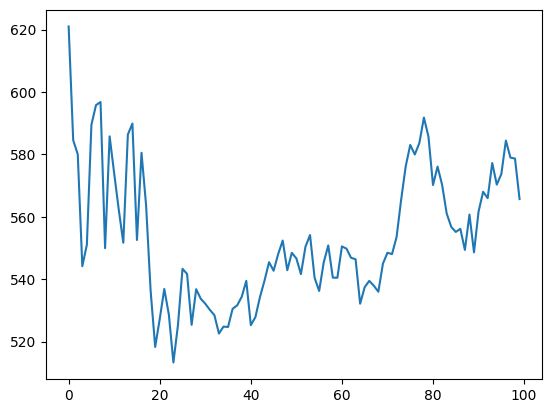

In [45]:
plt.plot(losses['train']['loss'])

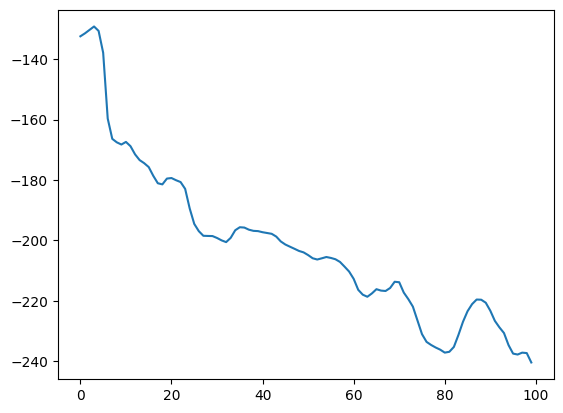

In [46]:
plt.plot(losses['train']['nll'])

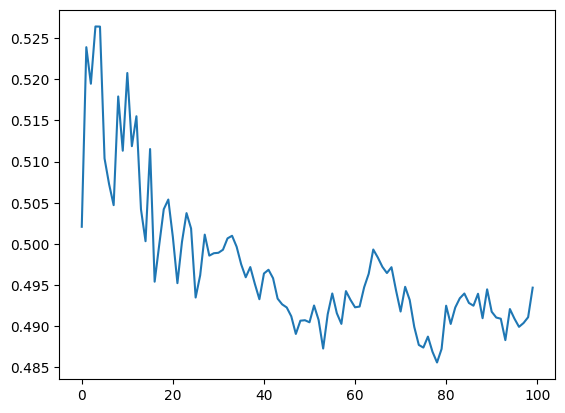

In [47]:
plt.plot(losses['train']['bpr'])